## Finite population dynamics

The diversity of life on Earth that we observe today is the result of evolution, which has taken place within finite populations, in conditions of limited resources.

To develop intuitions about this evolutionary process, we want to study various scenarios in an object-oriented simulation.

Think about the objects that you may use. At the minimum, we would have to represent:
- **Individual** - characterized primarily by its genome, i.e. a string of nucleotides (A, C, G, T). Should be able to make a copy of itself, potentially imperfect copy (with mutations).
- **Population** - composed of all individuals that are "alive" at a given time. We should be able to initialize the population in various ways, as well as evolve it in a various ways. One scenario, at which we will also look in the lecture, is replicating the population generation by generation, creating a new generation by sampling, with replacement, and replicating individuals from the old generation.

The implementation should allow us to ask questions like the following:
1. What is the trace of ancestors of an individual in the current population?
2. How many generations ago did two individuals have a common ancestor?
3. How long ago did **all** individuals from the current generation have a common ancestor?
4. What is the genetic distance between two individuals in the current population?
5. What is the relationship between the population size and the time to the most recent common ancestor?


In [1]:
import os, sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'population_dynamics'))
from population import Population  # jupyter import bug, is fine
from individual import Individual  # jupyter import bug, is fine
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd

In [2]:
# Set population parameters and initialize
initial_size = 20
genome_length = 500
mutation_rate = 0

# Initialize population
my_pop = Population(initial_size, genome_length, mutation_rate)
print(str(my_pop))

Generation #0, Population size: 20
Individual #0, 6e0afb: GTTGATAGAGTATCCCTATTTCATGCGCAAGTATCGTTGCACGACGACTTAGACTCAGCGTGCACTATTATTGCACGGAGCCCAGTCAAATACGCGAAAGATTTGGGTGAGTAGGCGTCTTGGAAAGACAATAACCGTTCGGGGTTTCGTCGAGTAAGTGTTCTCACTACGACGTAGAAATCCGCTATAGCATGAGTAAACGGACCGGGGAGACATAGTCAATTGTGCGCGATGGAGAACTTTGGTTACTTCAGGATTTTAAGCATCGGGCTAGCTCATCGTCCGACAGGTGTCTGTTGGGTTCGTATCCTGTCCGGCGCCAAACTTAGATACAGCCCAACCTATCTTTGACGTACACGCAGGAGGCCTAGCTTAATCCTTACCTTGCTATTTGCGCCCAGCTATCAGCTTCAGTGACGACCGTCCGCGAAGAACCCATTTTACGGCGCATGCATTTGTCTATTGATTGGTAGTCACGACCGTTCTTGTACCGTCCGGGA
Individual #1, 8ecdd4: AATGCCGCTCTGGGACACTTCAATCTCCACATACAGCCGTCCTTTAATGCTTGACGCCAAACTTACTTCACCGCACCTGCTCGCCGGAGAGGTCGAATCCTCAGCGTTCACTTGCGCCCAAGTAATAGGCATCAGTAAAGTTCGTATCGCTGTCGCAACACGCGTCCGCTGTCACGTACGCTGCGCGACTTATTTTGTAACGAGGCCCTTGCTAGGCCATAACTCCAAATCAGGCCGGCCCGTGGGGCACTCCTCGCCGCGGACCTGATAGGGTTGAAAATCCGTACTGTTGAGCTCCTAGGTGCCAATACCCATCAGTCGGCCATTCCGACTGCACTGTCCAGGGTTTTCAGAACGGAGTTTGACTGTACCGCATATAACTGCGAAGACGTGGTGAGAACACCGGAGCGGGTAAACG

In [3]:
# Evolve population in iterative steps
number_of_generations = 40
print("Evolving for " + str(number_of_generations) + " generations")
for p_i in range(number_of_generations):
    my_pop.get_next_generation()

print(str(my_pop))

Evolving for 40 generations
Generation #40, Population size: 20
Individual #0, 999939: TAATTGTCCAGAGTCCGATCTACATCATGAGCGACAACGTTTTTCGGAGAGACCTAAGGTCCCATACAATTTGTAGACGAGGACGACGGTCCCGTCTGCGATCGAAATATTTGCCATACGTTCTATTTGGTTGTTGGGATTTCATCGGTGTGCCATGACGCTCTCTAGTTGGATTAGTAATTATAATCGCGCCTGGAACTAATAGACTGTGAAGTGTTTAGGGGTTGACAACCGCACCACCGCAGACATGTCTGCGACAGGTCATCCTCCTTCGAGTGCCATCCCGCAACCACAAAGTTTGCGGAGACAATAACGCGGGTCCTCTCAGGCCCACTTAGGAAAGTCACCAGTATGTTCGCCAGACAATTCGTGCTTTCAGATCTTTGTTGACAGTAACCGAGAGACGAATCTTGTGAAAGAACGTTCAACGGATGGGCTGCCTTCAGTCCAAAGGACTGGCGGATGACAGAGCGGGCAGACAGGTGGTACCGTCTCATCGA
Individual #1, fd5cb0: TAATTGTCCAGAGTCCGATCTACATCATGAGCGACAACGTTTTTCGGAGAGACCTAAGGTCCCATACAATTTGTAGACGAGGACGACGGTCCCGTCTGCGATCGAAATATTTGCCATACGTTCTATTTGGTTGTTGGGATTTCATCGGTGTGCCATGACGCTCTCTAGTTGGATTAGTAATTATAATCGCGCCTGGAACTAATAGACTGTGAAGTGTTTAGGGGTTGACAACCGCACCACCGCAGACATGTCTGCGACAGGTCATCCTCCTTCGAGTGCCATCCCGCAACCACAAAGTTTGCGGAGACAATAACGCGGGTCCTCTCAGGCCCACTTAGGAAAGTCACCAGTATGTTCGCCAGACAATTCGTGCTTTCAGATCTTTGTTG

In [4]:
# Print ancestor trace of a given individual
individual_index = 0
my_pop.individuals[individual_index].print_ancestor_tree()

Ancestor tree for Individual 999939:
0. Self: 999939 - TAATTGTCCAGAGTCCGATCTACATCATGAGCGACAACGTTTTTCGGAGAGACCTAAGGTCCCATACAATTTGTAGACGAGGACGACGGTCCCGTCTGCGATCGAAATATTTGCCATACGTTCTATTTGGTTGTTGGGATTTCATCGGTGTGCCATGACGCTCTCTAGTTGGATTAGTAATTATAATCGCGCCTGGAACTAATAGACTGTGAAGTGTTTAGGGGTTGACAACCGCACCACCGCAGACATGTCTGCGACAGGTCATCCTCCTTCGAGTGCCATCCCGCAACCACAAAGTTTGCGGAGACAATAACGCGGGTCCTCTCAGGCCCACTTAGGAAAGTCACCAGTATGTTCGCCAGACAATTCGTGCTTTCAGATCTTTGTTGACAGTAACCGAGAGACGAATCTTGTGAAAGAACGTTCAACGGATGGGCTGCCTTCAGTCCAAAGGACTGGCGGATGACAGAGCGGGCAGACAGGTGGTACCGTCTCATCGA
1. Parent: 202ce1 - TAATTGTCCAGAGTCCGATCTACATCATGAGCGACAACGTTTTTCGGAGAGACCTAAGGTCCCATACAATTTGTAGACGAGGACGACGGTCCCGTCTGCGATCGAAATATTTGCCATACGTTCTATTTGGTTGTTGGGATTTCATCGGTGTGCCATGACGCTCTCTAGTTGGATTAGTAATTATAATCGCGCCTGGAACTAATAGACTGTGAAGTGTTTAGGGGTTGACAACCGCACCACCGCAGACATGTCTGCGACAGGTCATCCTCCTTCGAGTGCCATCCCGCAACCACAAAGTTTGCGGAGACAATAACGCGGGTCCTCTCAGGCCCACTTAGGAAAGTCACCAGTATGTTCGCCAGACAATTCGTGCTTTCAGATCTTTGTTGACAGTAACCGAGAGACGAATCTTGTGAAAGAACGT

In [5]:
# Find how many generations ago two individuals shared a common ancestor
individual_index_1 = 0
individual_index_2 = 8
current_generation = len(my_pop.generations) - 1

# Find common ancestor
_, _, common_ancestor = (my_pop.
                   find_most_recent_common_ancestor(
                                                    (my_pop.individuals[individual_index_1],
                                                     my_pop.individuals[individual_index_2])))

# Find common ancestor
# a, b = (my_pop.
#                    find_most_recent_common_ancestor(
#                                                     (my_pop.individuals[individual_index_1],
#                                                      my_pop.individuals[individual_index_2])))

if common_ancestor:
    print(f"Individuals {str(individual_index_1)} and "+
        f"{str(individual_index_2)} in this Generation #{len(my_pop.generations)-1}\n"+
        f"share a common ancestor:\n{repr(common_ancestor)}")
else:
    print(f"Individuals {str(individual_index_1)} and "+
        f"{str(individual_index_2)} in this Generation #{len(my_pop.generations)-1}\n "+
        "do not share a common ancestor")

Individuals 0 and 8 in this Generation #40
share a common ancestor:
Individual ID: 647640fc-b453-43e8-890d-2d642e3d50c0
Generation: 28
Genome: TAATTGTCCAGAGTCCGATCTACATCATGAGCGACAACGTTTTTCGGAGAGACCTAAGGTCCCATACAATTTGTAGACGAGGACGACGGTCCCGTCTGCGATCGAAATATTTGCCATACGTTCTATTTGGTTGTTGGGATTTCATCGGTGTGCCATGACGCTCTCTAGTTGGATTAGTAATTATAATCGCGCCTGGAACTAATAGACTGTGAAGTGTTTAGGGGTTGACAACCGCACCACCGCAGACATGTCTGCGACAGGTCATCCTCCTTCGAGTGCCATCCCGCAACCACAAAGTTTGCGGAGACAATAACGCGGGTCCTCTCAGGCCCACTTAGGAAAGTCACCAGTATGTTCGCCAGACAATTCGTGCTTTCAGATCTTTGTTGACAGTAACCGAGAGACGAATCTTGTGAAAGAACGTTCAACGGATGGGCTGCCTTCAGTCCAAAGGACTGGCGGATGACAGAGCGGGCAGACAGGTGGTACCGTCTCATCGA


In [6]:
# Find out how long ago all individuals shared a common ancestor
tmrca, mrca_individual = my_pop.time_to_most_recent_common_ancestor()

print(f"Time to most recent common ancestor: {tmrca} generations\n{repr(mrca_individual)}")

Time to most recent common ancestor: 12 generations
Individual ID: 647640fc-b453-43e8-890d-2d642e3d50c0
Generation: 28
Genome: TAATTGTCCAGAGTCCGATCTACATCATGAGCGACAACGTTTTTCGGAGAGACCTAAGGTCCCATACAATTTGTAGACGAGGACGACGGTCCCGTCTGCGATCGAAATATTTGCCATACGTTCTATTTGGTTGTTGGGATTTCATCGGTGTGCCATGACGCTCTCTAGTTGGATTAGTAATTATAATCGCGCCTGGAACTAATAGACTGTGAAGTGTTTAGGGGTTGACAACCGCACCACCGCAGACATGTCTGCGACAGGTCATCCTCCTTCGAGTGCCATCCCGCAACCACAAAGTTTGCGGAGACAATAACGCGGGTCCTCTCAGGCCCACTTAGGAAAGTCACCAGTATGTTCGCCAGACAATTCGTGCTTTCAGATCTTTGTTGACAGTAACCGAGAGACGAATCTTGTGAAAGAACGTTCAACGGATGGGCTGCCTTCAGTCCAAAGGACTGGCGGATGACAGAGCGGGCAGACAGGTGGTACCGTCTCATCGA


In [7]:
# Calculate and report genetic distance between two individuals in current population
individual_index_1 = 0
individual_index_2 = 8
genetic_distance = my_pop.individuals[individual_index_1].get_genetic_distance(
    my_pop.individuals[individual_index_2])
# Similarity as 1 - dissimilarity
genetic_similarity = (1 - genetic_distance/len(my_pop.individuals[individual_index_1].genome))*100
print(f"Genetic distance between individuals {individual_index_1} and {individual_index_2}: {genetic_distance}\n"+
      f"#{individual_index_1} {repr(my_pop.individuals[individual_index_1])}\n"+
      f"#{individual_index_2} {repr(my_pop.individuals[individual_index_2])}\n"+
      f"Genetic similarity: {genetic_similarity:.2f}%")

Genetic distance between individuals 0 and 8: 0
#0 Individual ID: 9999391a-103b-494d-b55d-8c64522fd3e9
Generation: 40
Genome: TAATTGTCCAGAGTCCGATCTACATCATGAGCGACAACGTTTTTCGGAGAGACCTAAGGTCCCATACAATTTGTAGACGAGGACGACGGTCCCGTCTGCGATCGAAATATTTGCCATACGTTCTATTTGGTTGTTGGGATTTCATCGGTGTGCCATGACGCTCTCTAGTTGGATTAGTAATTATAATCGCGCCTGGAACTAATAGACTGTGAAGTGTTTAGGGGTTGACAACCGCACCACCGCAGACATGTCTGCGACAGGTCATCCTCCTTCGAGTGCCATCCCGCAACCACAAAGTTTGCGGAGACAATAACGCGGGTCCTCTCAGGCCCACTTAGGAAAGTCACCAGTATGTTCGCCAGACAATTCGTGCTTTCAGATCTTTGTTGACAGTAACCGAGAGACGAATCTTGTGAAAGAACGTTCAACGGATGGGCTGCCTTCAGTCCAAAGGACTGGCGGATGACAGAGCGGGCAGACAGGTGGTACCGTCTCATCGA
#8 Individual ID: de383c2d-265f-4eeb-849a-844bbc1c3066
Generation: 40
Genome: TAATTGTCCAGAGTCCGATCTACATCATGAGCGACAACGTTTTTCGGAGAGACCTAAGGTCCCATACAATTTGTAGACGAGGACGACGGTCCCGTCTGCGATCGAAATATTTGCCATACGTTCTATTTGGTTGTTGGGATTTCATCGGTGTGCCATGACGCTCTCTAGTTGGATTAGTAATTATAATCGCGCCTGGAACTAATAGACTGTGAAGTGTTTAGGGGTTGACAACCGCACCACCGCAGACATGTCTGCGACAGGTCATCCTCCTTCGAGTGCCATCCCGCAACCACAA

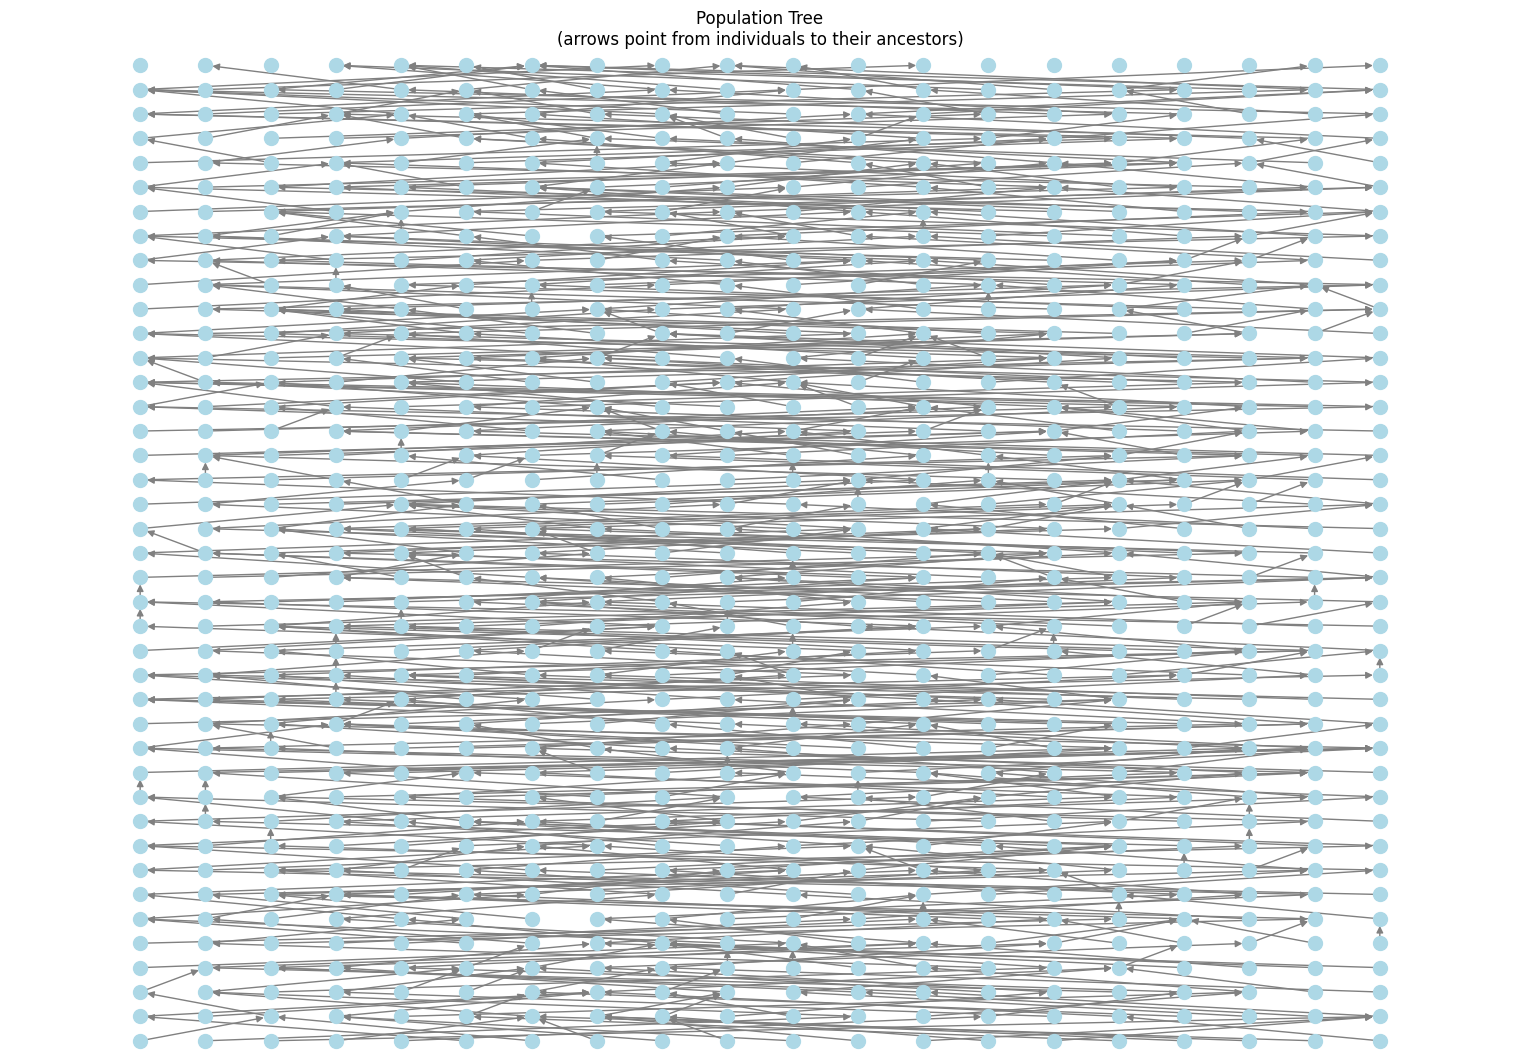

In [8]:
import networkx as nx

import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes for all individuals in all generations
positions = {}
for gen_idx, generation in enumerate(my_pop.generations):
    y_pos = -gen_idx  # Negative to have first generation at top
    for ind_idx, individual in enumerate(generation):
        # Use individual's ID as node identifier
        node_id = individual.id
        G.add_node(node_id)
        # Position nodes in a row for each generation
        x_pos = (ind_idx - len(generation)/2) / len(generation)  # Center individuals horizontally
        positions[node_id] = (x_pos, y_pos)

# Add edges (arrows) from individuals to their parents
for gen_idx, generation in enumerate(my_pop.generations[1:], 1):  # Start from second generation
    for individual in generation:
        if hasattr(individual, 'parent') and individual.parent:
            G.add_edge(individual.id, individual.parent.id)

# Create the plot
plt.figure(figsize=(15, 10))
nx.draw(G, pos=positions, 
        node_size=100,
        node_color='lightblue',
        edge_color='gray',
        arrowsize=10,
        with_labels=False)

# Add generation labels on the y-axis
plt.ylim(-(len(my_pop.generations)-0.5), 0.5)
plt.title('Population Tree\n(arrows point from individuals to their ancestors)')
plt.show()